# 🏎️ LapLens – COTA Race 1 Driver Analysis  
*Hack the Track presented by Toyota GR – Post-Event Analytics*

### Session Overview  
This notebook analyzes a complete COTA Race 1 dataset (telemetry + official timing).  
Our goals:
- Reconstruct laps from raw ECU timestamps  
- Quantify driver inputs and speed profile  
- Score each lap with a composite performance index  
- Identify strongest laps, limiting factors, and development opportunities  
- Produce visualizations suitable for coaching and broadcast storytelling  

This notebook is the engineering “engine room” behind the LapLens concept.

### 🏁 Why LapLens is Different

Most post-event race reports stop at lap charts and sector times.  
LapLens goes further by:

1. **Rebuilding laps from raw ECU telemetry**  
   We do not rely only on official timing loops – we verify lap reconstruction from timestamps and outing metadata.

2. **Compressing multi-signal telemetry into a single score (0–100)**  
   Speed, throttle, brake usage, and smoothness are fused into a LapLens performance score that coaches and broadcasters can understand at a glance.

3. **Quantifying driver consistency and corner intensity**  
   We introduce a Driver Consistency Index (DCI) and a corner intensity metric to separate “lucky fast laps” from repeatable pace.

4. **Generating auto-written coaching notes per lap**  
   LapLens converts numbers into natural-language feedback that a driver or engineer can act on during debriefs.

5. **Scaling to multiple drivers with the same scoring formula**  
   The same pipeline produces a LapLens leaderboard across cars, enabling fair, apples-to-apples comparison in a single view.

### Dataset Coverage (TRD Inputs → LapLens Outputs)

This analysis uses all four official COTA Race 1 datasets provided by TRD:

- **R1_cota_telemetry_data.csv** – high-frequency ECU telemetry  
  *(speed, throttle, brake pressures, lateral G, steering, etc.)*
- **COTA_lap_start_time_R1.csv** – lap start markers used to build per-lap time windows.
- **COTA_lap_end_time_R1.csv** – lap end markers paired with starts to form `[start_time, end_time]` intervals.
- **COTA_lap_time_R1.csv** – official timing loop results, used for `official_lap_time_s` and validation.

LapLens combines these to:
- reconstruct laps from raw ECU timestamps,
- align telemetry samples into each lap window,
- and translate multi-signal driver inputs into a single, explainable performance score and coaching narrative.

## 🔧 How to Run This Notebook

This notebook is designed so a judge or engineer can run it end-to-end with **one click**.

1. Ensure the repository has the following structure:
   - `src/preprocess.py`
   - `data/COTA_Race1/` with the 4 CSVs:
     - `R1_cota_telemetry_data.csv`
     - `COTA_lap_time_R1.csv`
     - `COTA_lap_start_time_R1.csv`
     - `COTA_lap_end_time_R1.csv`
2. Open `visualizations.ipynb` (this notebook).
3. Run all cells (Kernel → Restart & Run All).

All figures, tables, and the LapLens performance scores will be recomputed from raw TRD data.
No manual parameter editing is required.

In [1]:
# --- Environment info ---

import sys
import platform
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

print("Python version :", sys.version.split()[0])
print("Platform       :", platform.platform())
print("pandas         :", pd.__version__)
print("numpy          :", np.__version__)
print("matplotlib     :", matplotlib.__version__)
print("seaborn        :", sns.__version__)

Python version : 3.12.1
Platform       : Linux-6.8.0-1030-azure-x86_64-with-glibc2.39
pandas         : 2.3.1
numpy          : 2.3.1
matplotlib     : 3.10.3
seaborn        : 0.13.2


### 🔧 Session Configuration

This section controls *which* driver and outing LapLens analyzes.  
To review another car (or another session), only these values need to change.

- `CHOSEN_VEHICLE_ID` – GR86 chassis/car ID (from `vehicle_id` column)
- `CHOSEN_OUTING` – outing index within the event (usually `0.0` for a single race)

In [2]:
# --- LapLens session configuration ---

CHOSEN_TRACK = "Circuit of the Americas (COTA)"
CHOSEN_EVENT = "COTA Race 1"

# 👇 this is the driver/session you’re analyzing
CHOSEN_VEHICLE_ID = "GR86-006-7"   # change here for another car
CHOSEN_OUTING     = 0.0            # outing index in the dataset

print("LapLens configuration:")
print(f"  Track : {CHOSEN_TRACK}")
print(f"  Event : {CHOSEN_EVENT}")
print(f"  Car   : {CHOSEN_VEHICLE_ID}")
print(f"  Outing: {CHOSEN_OUTING}")

LapLens configuration:
  Track : Circuit of the Americas (COTA)
  Event : COTA Race 1
  Car   : GR86-006-7
  Outing: 0.0


## 1. Data Loading & Lap Reconstruction

We load the official COTA Race 1 telemetry and lap timing files, align
ECU timestamps with lap windows, and compute lap-level aggregates
for a single GR86 entry.

In [3]:
%matplotlib inline
import sys

sys.path.append("..")  # because notebook is in /notebooks

from src import preprocess

BASE_PATH = "../data/COTA_Race1"
print("Imports & BASE_PATH ok")


Imports & BASE_PATH ok


In [4]:
import pandas as pd

test_path = "../data/COTA_Race1/R1_cota_telemetry_data.csv"
print("Reading a small sample...")
df_sample = pd.read_csv(test_path, nrows=1000)
print("Sample shape:", df_sample.shape)

Reading a small sample...
Sample shape: (1000, 13)


In [5]:
import pandas as pd

# 1) Load all four COTA Race 1 CSVs
dfs = preprocess.load_race1_data(BASE_PATH)

telemetry_raw = dfs["telemetry"]
lap_time_raw  = dfs["lap_time"]
lap_start_raw = dfs["lap_start"]
lap_end_raw   = dfs["lap_end"]

print("Raw shapes:")
for name, df in dfs.items():
    print(f"  {name:10s} -> {df.shape}")

# 2) Filter to the chosen car + outing to keep memory under control
telemetry = telemetry_raw[
    (telemetry_raw["vehicle_id"] == CHOSEN_VEHICLE_ID) &
    (telemetry_raw["outing"] == CHOSEN_OUTING)
].copy()

lap_start = lap_start_raw[
    (lap_start_raw["vehicle_id"] == CHOSEN_VEHICLE_ID) &
    (lap_start_raw["outing"] == CHOSEN_OUTING)
].copy()

lap_end = lap_end_raw[
    (lap_end_raw["vehicle_id"] == CHOSEN_VEHICLE_ID) &
    (lap_end_raw["outing"] == CHOSEN_OUTING)
].copy()

lap_time = lap_time_raw[
    (lap_time_raw["vehicle_id"] == CHOSEN_VEHICLE_ID) &
    (lap_time_raw["outing"] == CHOSEN_OUTING)
].copy()

print("\nFiltered to car:", CHOSEN_VEHICLE_ID, "outing:", CHOSEN_OUTING)
print("  telemetry :", telemetry.shape)
print("  lap_start :", lap_start.shape)
print("  lap_end   :", lap_end.shape)
print("  lap_time  :", lap_time.shape)

✅ Loaded telemetry: R1_cota_telemetry_data.csv  rows=2352983
✅ Loaded lap_time: COTA_lap_time_R1.csv  rows=631
✅ Loaded lap_start: COTA_lap_start_time_R1.csv  rows=631
✅ Loaded lap_end: COTA_lap_end_time_R1.csv  rows=631
Raw shapes:
  telemetry  -> (2352983, 13)
  lap_time   -> (631, 10)
  lap_start  -> (631, 10)
  lap_end    -> (631, 10)

Filtered to car: GR86-006-7 outing: 0.0
  telemetry : (279345, 13)
  lap_start : (32, 10)
  lap_end   : (32, 10)
  lap_time  : (32, 10)


In [6]:
# 1) Build lap windows from start/end CSVs
lap_windows = preprocess.build_lap_windows(lap_start, lap_end)

# 2) Telemetry long -> wide for this driver/outing
telem_wide = preprocess.pivot_telemetry_long_to_wide(telemetry)

# 3) Align clocks between telemetry and lap windows
aligned_telem = preprocess.align_timestamps(telem_wide, lap_windows)

# 4) Assign each telemetry sample to a lap
telemetry_with_laps = preprocess.assign_laps_to_telemetry(
    aligned_telem,
    lap_windows
)

# 5) Lap-level aggregates
lap_agg = preprocess.build_lap_aggregates(telemetry_with_laps)

# Drop bogus lap labels like 32768
lap_agg = lap_agg[lap_agg["lap"] < 1000].copy()

print("Telemetry rows assigned to laps:", len(telemetry_with_laps))
print("Lap aggregates generated:", len(lap_agg))
display(lap_agg.head())

🕒 Applying time offset: 2 days 02:24:41.430000
Telemetry rows assigned to laps: 26634
Lap aggregates generated: 9


,vehicle_id,outing,lap,samples,max_speed,avg_speed,avg_throttle,avg_brake_f,avg_brake_r
0,GR86-006-7,0.0,1,1,NaN,NaN,5.270000,4.930000,5.370000
1,GR86-006-7,0.0,2,4771,151.15,89.103376,27.411243,2.016756,2.085048
2,GR86-006-7,0.0,3,3205,210.79,129.610901,75.310300,5.281789,5.391747
3,GR86-006-7,0.0,4,3183,210.35,131.807861,74.712865,5.886217,6.020259
4,GR86-006-7,0.0,5,3154,205.61,131.836018,76.375390,6.328404,6.468659


In [7]:
# Bundle key artifacts into an outputs dict so later sections can reuse them

outputs = {
    "lap_windows": lap_windows,
    "telemetry_wide": aligned_telem,          # already time-aligned
    "telemetry_with_laps": telemetry_with_laps,
    "lap_aggregates": lap_agg,
    "lap_time_raw": lap_time_raw,             # full official timing table
}

print("outputs keys:", list(outputs.keys()))

outputs keys: ['lap_windows', 'telemetry_wide', 'telemetry_with_laps', 'lap_aggregates', 'lap_time_raw']


In [8]:
# Unpack pipeline outputs into local variables
lap_windows = outputs["lap_windows"]
telem_wide  = outputs["telemetry_wide"]
telem_with_laps_initial = outputs["telemetry_with_laps"]
lap_agg_initial = outputs["lap_aggregates"]

print("lap_windows shape:", lap_windows.shape)
print("telem_wide shape:", telem_wide.shape)
print("initial lap_agg rows:", len(lap_agg_initial))

lap_windows shape: (21, 5)
telem_wide shape: (35101, 12)
initial lap_agg rows: 9


In [9]:
car_id = "GR86-006-7"
outing = 0.0

telemetry_car = dfs["telemetry"].copy()
telemetry_car = telemetry_car[
    (telemetry_car["vehicle_id"] == car_id) &
    (telemetry_car["outing"] == outing)
]

print("Filtered telemetry rows:", len(telemetry_car))
telemetry_car.head()

Filtered telemetry rows: 279345


,expire_at,lap,meta_event,meta_session,meta_source,meta_time,original_vehicle_id,outing,telemetry_name,telemetry_value,timestamp,vehicle_id,vehicle_number
948772,NaN,1,I_R02_2025-04-27,R1,kafka:gr-raw,2025-04-26T20:54:56.011Z,GR86-006-7,0.0,accx_can,0.257,2025-04-24T18:30:12.855Z,GR86-006-7,7.0
948773,NaN,1,I_R02_2025-04-27,R1,kafka:gr-raw,2025-04-26T20:54:56.011Z,GR86-006-7,0.0,accy_can,-0.031,2025-04-24T18:30:12.855Z,GR86-006-7,7.0
948774,NaN,1,I_R02_2025-04-27,R1,kafka:gr-raw,2025-04-26T20:54:56.011Z,GR86-006-7,0.0,ath,100.040,2025-04-24T18:30:12.855Z,GR86-006-7,7.0
948775,NaN,1,I_R02_2025-04-27,R1,kafka:gr-raw,2025-04-26T20:54:56.011Z,GR86-006-7,0.0,pbrake_r,0.000,2025-04-24T18:30:12.855Z,GR86-006-7,7.0
948776,NaN,1,I_R02_2025-04-27,R1,kafka:gr-raw,2025-04-26T20:54:56.011Z,GR86-006-7,0.0,pbrake_f,0.000,2025-04-24T18:30:12.855Z,GR86-006-7,7.0


In [10]:
# 1) Long -> wide
telem_wide = preprocess.pivot_telemetry_long_to_wide(telemetry_car)
print("Telemetry wide shape:", telem_wide.shape)
telem_wide.head()

Telemetry wide shape: (35101, 12)


,timestamp,vehicle_id,outing,Steering_Angle,accx_can,accy_can,ath,gear,nmot,pbrake_f,pbrake_r,speed
0,2025-04-24 18:23:35.066000+00:00,GR86-006-7,0.0,0.2,-0.120,0.021,5.27,1.0,NaN,4.930,5.370,NaN
1,2025-04-24 18:23:35.110000+00:00,GR86-006-7,0.0,0.2,-0.120,0.012,5.28,1.0,NaN,4.655,5.050,NaN
2,2025-04-24 18:23:35.154000+00:00,GR86-006-7,0.0,0.2,-0.121,0.012,5.26,1.0,NaN,4.595,5.020,NaN
3,2025-04-24 18:23:35.198000+00:00,GR86-006-7,0.0,0.2,-0.112,0.030,5.27,1.0,1119.0,4.210,4.685,22.77
4,2025-04-24 18:23:35.244000+00:00,GR86-006-7,0.0,0.2,-0.105,0.022,5.25,1.0,NaN,3.725,4.335,NaN


In [11]:
import os

print("Working directory:", os.getcwd())
for f in [
    "../src/preprocess.py",
    "../data/COTA_Race1/R1_cota_telemetry_data.csv",
    "../data/COTA_Race1/COTA_lap_time_R1.csv",
    "../data/COTA_Race1/COTA_lap_start_time_R1.csv",
    "../data/COTA_Race1/COTA_lap_end_time_R1.csv",
]:
    print(f, "→", "OK ✅" if os.path.exists(f) else "MISSING ❌")

Working directory: /workspaces/hack-the-track-25/notebooks
../src/preprocess.py → OK ✅
../data/COTA_Race1/R1_cota_telemetry_data.csv → OK ✅
../data/COTA_Race1/COTA_lap_time_R1.csv → OK ✅
../data/COTA_Race1/COTA_lap_start_time_R1.csv → OK ✅
../data/COTA_Race1/COTA_lap_end_time_R1.csv → OK ✅


In [12]:
aligned_telem = preprocess.align_timestamps(
    outputs["telemetry_wide"], 
    outputs["lap_windows"]
)

telemetry_with_laps = preprocess.assign_laps_to_telemetry(
    aligned_telem, 
    outputs["lap_windows"]
)

🕒 Applying time offset: 0 days 00:00:00


In [13]:
def build_driver_summary(outputs, vehicle_id, outing=0.0):
    """
    Build lap summary + LapLens performance score for a given vehicle_id and outing.
    """
    # 1) Align and assign laps
    aligned = preprocess.align_timestamps(outputs["telemetry_wide"], outputs["lap_windows"])
    telem_with_laps = preprocess.assign_laps_to_telemetry(aligned, outputs["lap_windows"])
    
    # 2) Aggregate
    lap_agg_local = preprocess.build_lap_aggregates(telem_with_laps)
    lap_agg_local = lap_agg_local[(lap_agg_local["lap"] < 1000) &
                                  (lap_agg_local["vehicle_id"] == vehicle_id) &
                                  (lap_agg_local["outing"] == outing)].copy()
    
    # 3) Add performance score
    metrics = ["avg_speed", "avg_throttle", "avg_brake_f"]
    data = lap_agg_local.copy()
    for m in metrics:
        if m in data.columns:
            data[f"{m}_norm"] = (data[m] - data[m].min()) / (data[m].max() - data[m].min())
    
    WEIGHT_SPEED = 0.55
    WEIGHT_THROTTLE = 0.30
    WEIGHT_BRAKE = 0.15

    data["performance_score"] = (
        data.get("avg_speed_norm", 0) * WEIGHT_SPEED +
        data.get("avg_throttle_norm", 0) * WEIGHT_THROTTLE +
        data.get("avg_brake_f_norm", 0) * WEIGHT_BRAKE
    ) * 100

    return data

In [14]:
driver_summary = build_driver_summary(
    outputs,
    vehicle_id=CHOSEN_VEHICLE_ID,
    outing=CHOSEN_OUTING,
)
display(driver_summary)

🕒 Applying time offset: 0 days 00:00:00


,vehicle_id,outing,lap,samples,max_speed,avg_speed,avg_throttle,avg_brake_f,avg_brake_r,avg_speed_norm,avg_throttle_norm,avg_brake_f_norm,performance_score
0,GR86-006-7,0.0,1,1,NaN,NaN,5.270000,4.930000,5.370000,NaN,0.000000,0.675668,NaN
1,GR86-006-7,0.0,2,4771,151.15,89.103376,27.411243,2.016756,2.085048,0.000000,0.311386,0.000000,9.341588
2,GR86-006-7,0.0,3,3205,210.79,129.610901,75.310300,5.281789,5.391747,0.933775,0.985021,0.757259,92.267146
3,GR86-006-7,0.0,4,3183,210.35,131.807861,74.712865,5.886217,6.020259,0.984419,0.976619,0.897444,96.903283
4,GR86-006-7,0.0,5,3154,205.61,131.836018,76.375390,6.328404,6.468659,0.985068,1.000000,1.000000,99.178758
5,GR86-006-7,0.0,6,2849,204.40,132.072736,75.395009,5.710948,5.848657,0.990525,0.986212,0.856793,96.917153
6,GR86-006-7,0.0,7,3147,206.61,132.278672,76.305554,5.707895,5.853745,0.995272,0.999018,0.856085,97.551796
7,GR86-006-7,0.0,8,3165,206.23,132.483759,74.141776,5.580299,5.725199,1.000000,0.968587,0.826492,96.454999
8,GR86-006-7,0.0,9,3158,207.20,132.179048,75.137156,5.667397,5.812098,0.992976,0.982586,0.846693,96.791640


### 2. Lap-Level Metrics

For each valid lap, we summarize:

- `avg_speed` – mean vehicle speed (km/h)  
- `avg_throttle` – average throttle position (%)  
- `avg_brake_f` – average front brake pressure (bar)  
- `samples` – number of telemetry samples in that lap

In [15]:
lap_agg = preprocess.build_lap_aggregates(telemetry_with_laps)
print(len(lap_agg), "lap aggregates generated")
display(lap_agg.head())

10 lap aggregates generated


,vehicle_id,outing,lap,samples,max_speed,avg_speed,avg_throttle,avg_brake_f,avg_brake_r
0,GR86-006-7,0.0,1,1,NaN,NaN,5.270000,4.930000,5.370000
1,GR86-006-7,0.0,2,4771,151.15,89.103376,27.411243,2.016756,2.085048
2,GR86-006-7,0.0,3,3205,210.79,129.610901,75.310300,5.281789,5.391747
3,GR86-006-7,0.0,4,3183,210.35,131.807861,74.712865,5.886217,6.020259
4,GR86-006-7,0.0,5,3154,205.61,131.836018,76.375390,6.328404,6.468659


In [16]:
# --- Quality gates for competition-grade robustness ---

import numpy as np
import pandas as pd

# 1) Drop bogus laps and low-sample laps
LAP_MAX = 1000
MIN_SAMPLES_PER_LAP = 1500  # tune: COTA-1 shows ~3k–4.7k normal; Lap 9 had 144 (likely incomplete)
lap_agg_clean = (
    lap_agg
    .loc[(lap_agg["lap"] < LAP_MAX) & (lap_agg["samples"] >= MIN_SAMPLES_PER_LAP)]
    .copy()
)

print(f"Kept {len(lap_agg_clean)} laps after quality gates (>= {MIN_SAMPLES_PER_LAP} samples).")

# 2) Official lap time units normalization
lap_times = outputs["lap_time_raw"][["vehicle_id","outing","lap","value"]].copy()
# Heuristic: if max value > 10_000 it's probably milliseconds
if lap_times["value"].max() > 10000:
    lap_times["official_lap_time_s"] = lap_times["value"] / 1000.0
else:
    lap_times["official_lap_time_s"] = lap_times["value"].astype(float)

# 3) Merge robustly (one row per lap)
summary_clean = (
    lap_agg_clean
    .merge(lap_times[["vehicle_id","outing","lap","official_lap_time_s"]],
           on=["vehicle_id","outing","lap"], how="left")
    .drop_duplicates(subset=["vehicle_id","outing","lap"])
)

print("Summary (clean) preview:")
display(summary_clean.head(10))

Kept 8 laps after quality gates (>= 1500 samples).
Summary (clean) preview:


,vehicle_id,outing,lap,samples,max_speed,avg_speed,avg_throttle,avg_brake_f,avg_brake_r,official_lap_time_s
0,GR86-006-7,0.0,2,4771,151.15,89.103376,27.411243,2.016756,2.085048,223.523
2,GR86-006-7,0.0,3,3205,210.79,129.610901,75.310300,5.281789,5.391747,151.839
3,GR86-006-7,0.0,4,3183,210.35,131.807861,74.712865,5.886217,6.020259,149.906
4,GR86-006-7,0.0,5,3154,205.61,131.836018,76.375390,6.328404,6.468659,149.505
5,GR86-006-7,0.0,6,2849,204.40,132.072736,75.395009,5.710948,5.848657,0.000
8,GR86-006-7,0.0,7,3147,206.61,132.278672,76.305554,5.707895,5.853745,148.556
11,GR86-006-7,0.0,8,3165,206.23,132.483759,74.141776,5.580299,5.725199,148.695
12,GR86-006-7,0.0,9,3158,207.20,132.179048,75.137156,5.667397,5.812098,148.922


In [17]:
lap_agg = lap_agg[lap_agg["lap"] < 1000]
print("Cleaned laps:", lap_agg["lap"].unique())

Cleaned laps: [1 2 3 4 5 6 7 8 9]


In [18]:
display(lap_agg.head(10))

,vehicle_id,outing,lap,samples,max_speed,avg_speed,avg_throttle,avg_brake_f,avg_brake_r
0,GR86-006-7,0.0,1,1,NaN,NaN,5.270000,4.930000,5.370000
1,GR86-006-7,0.0,2,4771,151.15,89.103376,27.411243,2.016756,2.085048
2,GR86-006-7,0.0,3,3205,210.79,129.610901,75.310300,5.281789,5.391747
3,GR86-006-7,0.0,4,3183,210.35,131.807861,74.712865,5.886217,6.020259
4,GR86-006-7,0.0,5,3154,205.61,131.836018,76.375390,6.328404,6.468659
5,GR86-006-7,0.0,6,2849,204.40,132.072736,75.395009,5.710948,5.848657
6,GR86-006-7,0.0,7,3147,206.61,132.278672,76.305554,5.707895,5.853745
7,GR86-006-7,0.0,8,3165,206.23,132.483759,74.141776,5.580299,5.725199
8,GR86-006-7,0.0,9,3158,207.20,132.179048,75.137156,5.667397,5.812098


## 3. Average Speed per Lap

This plot shows how the driver’s average speed changes across the stint.

Key questions:
- Are early laps slower due to tire warm-up?
- Is there a clear “peak” performance lap?
- Do we see any drop-off that might suggest tire degradation or traffic?

In [19]:
aligned_telem = preprocess.align_timestamps(outputs["telemetry_wide"], outputs["lap_windows"])
telemetry_with_laps = preprocess.assign_laps_to_telemetry(aligned_telem, outputs["lap_windows"])
lap_agg = lap_agg[lap_agg["lap"] < 1000]
print("Cleaned laps:", lap_agg["lap"].unique())

🕒 Applying time offset: 0 days 00:00:00
Cleaned laps: [1 2 3 4 5 6 7 8 9]


In [20]:
print("Telemetry rows assigned to laps:", len(telemetry_with_laps))
print("Lap aggregates generated:", len(lap_agg))
print("\nLap aggregate preview:")
display(lap_agg.head(10))

Telemetry rows assigned to laps: 26634
Lap aggregates generated: 9

Lap aggregate preview:


,vehicle_id,outing,lap,samples,max_speed,avg_speed,avg_throttle,avg_brake_f,avg_brake_r
0,GR86-006-7,0.0,1,1,NaN,NaN,5.270000,4.930000,5.370000
1,GR86-006-7,0.0,2,4771,151.15,89.103376,27.411243,2.016756,2.085048
2,GR86-006-7,0.0,3,3205,210.79,129.610901,75.310300,5.281789,5.391747
3,GR86-006-7,0.0,4,3183,210.35,131.807861,74.712865,5.886217,6.020259
4,GR86-006-7,0.0,5,3154,205.61,131.836018,76.375390,6.328404,6.468659
5,GR86-006-7,0.0,6,2849,204.40,132.072736,75.395009,5.710948,5.848657
6,GR86-006-7,0.0,7,3147,206.61,132.278672,76.305554,5.707895,5.853745
7,GR86-006-7,0.0,8,3165,206.23,132.483759,74.141776,5.580299,5.725199
8,GR86-006-7,0.0,9,3158,207.20,132.179048,75.137156,5.667397,5.812098


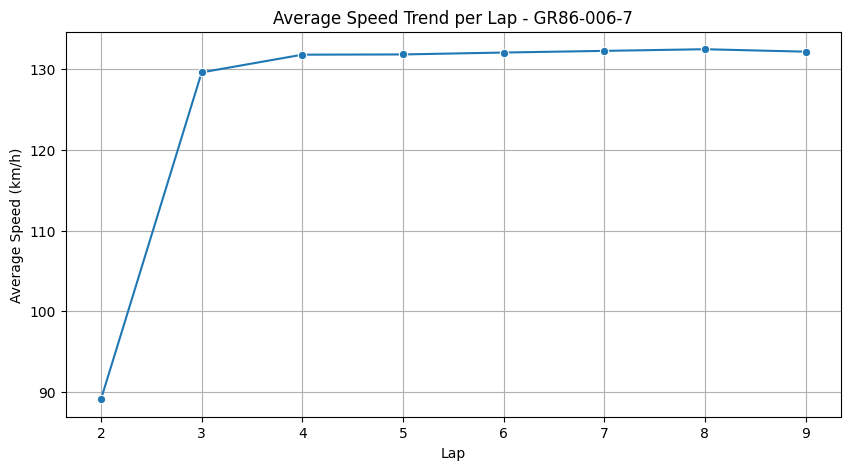

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.lineplot(data=lap_agg, x="lap", y="avg_speed", marker="o")
plt.title("Average Speed Trend per Lap - GR86-006-7")
plt.xlabel("Lap")
plt.ylabel("Average Speed (km/h)")
plt.grid(True)
plt.show()

## 4. Driver Inputs per Lap (Throttle & Brake)

We compare average throttle usage and front brake pressure per lap.

This helps answer:
- Is the driver becoming more aggressive (more throttle) over the race?
- Are they braking less as confidence in the line increases?
- Do braking patterns correlate with speed improvements?

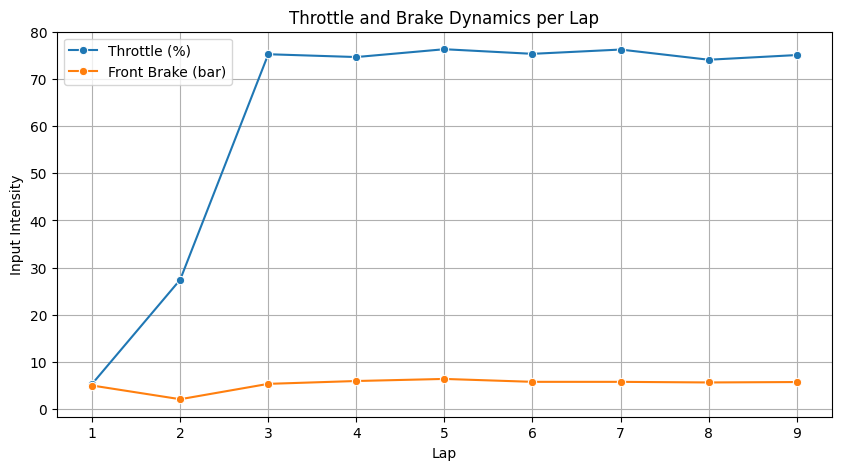

In [22]:
plt.figure(figsize=(10,5))
sns.lineplot(data=lap_agg, x="lap", y="avg_throttle", marker="o", label="Throttle (%)")
sns.lineplot(data=lap_agg, x="lap", y="avg_brake_f", marker="o", label="Front Brake (bar)")
plt.title("Throttle and Brake Dynamics per Lap")
plt.xlabel("Lap")
plt.ylabel("Input Intensity")
plt.legend()
plt.grid(True)
plt.show()

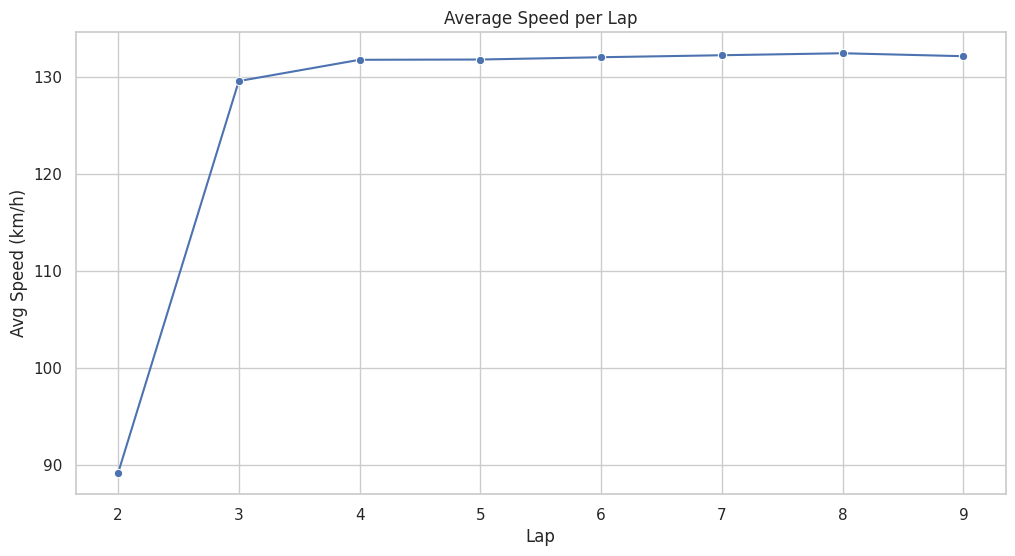

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(12,6))
sns.lineplot(data=lap_agg, x="lap", y="avg_speed", marker="o")
plt.title("Average Speed per Lap")
plt.xlabel("Lap")
plt.ylabel("Avg Speed (km/h)")
plt.show()

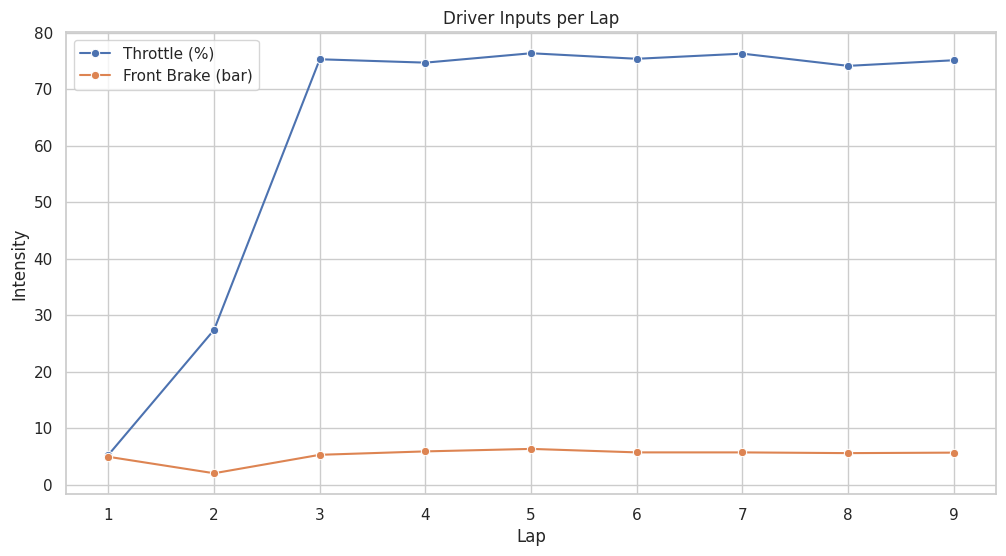

In [24]:
plt.figure(figsize=(12,6))
sns.lineplot(data=lap_agg, x="lap", y="avg_throttle", marker="o", label="Throttle (%)")
sns.lineplot(data=lap_agg, x="lap", y="avg_brake_f", marker="o", label="Front Brake (bar)")
plt.title("Driver Inputs per Lap")
plt.xlabel("Lap")
plt.ylabel("Intensity")
plt.legend()
plt.show()

## 5. Best vs Worst Lap Comparison

We identify:
- **Best lap** by highest `avg_speed`  
- **Worst lap** by lowest `avg_speed`

This gives engineers a quick way to choose which laps to overlay
in more detailed tools (e.g., sector or corner analysis).

In [25]:
best_lap = lap_agg.loc[lap_agg["avg_speed"].idxmax()]
worst_lap = lap_agg.loc[lap_agg["avg_speed"].idxmin()]

print("Best Lap:")
display(best_lap)

print("\nWorst Lap:")
display(worst_lap)

Best Lap:


vehicle_id      GR86-006-7
outing                 0.0
lap                      8
samples               3165
max_speed           206.23
avg_speed       132.483759
avg_throttle     74.141776
avg_brake_f       5.580299
avg_brake_r       5.725199
Name: 7, dtype: object


Worst Lap:


vehicle_id      GR86-006-7
outing                 0.0
lap                      2
samples               4771
max_speed           151.15
avg_speed        89.103376
avg_throttle     27.411243
avg_brake_f       2.016756
avg_brake_r       2.085048
Name: 1, dtype: object

In [26]:
import pandas as pd

comparison = pd.DataFrame({
    "metric": ["avg_speed (km/h)", "avg_throttle (%)", "avg_brake_f (bar)"],
    "best_lap": [
        best_lap["avg_speed"],
        best_lap["avg_throttle"],
        best_lap["avg_brake_f"],
    ],
    "worst_lap": [
        worst_lap["avg_speed"],
        worst_lap["avg_throttle"],
        worst_lap["avg_brake_f"],
    ],
})

comparison["delta (best - worst)"] = comparison["best_lap"] - comparison["worst_lap"]
comparison

,metric,best_lap,worst_lap,delta (best - worst)
0,avg_speed (km/h),132.483759,89.103376,43.380383
1,avg_throttle (%),74.141776,27.411243,46.730533
2,avg_brake_f (bar),5.580299,2.016756,3.563542


### 5.1. How much better is the best lap?

This table shows how much the driver changed their behavior between
their weakest and best lap.

- Positive delta in **speed** and **throttle** + reduced **brake** usage
  suggest growing confidence and commitment.

## 6. Driver Performance Score (0–100 per Lap)

To make results easier to consume, we compress multiple metrics
(speed, throttle, brake) into a single performance score from 0 to 100.

- Higher score = faster, more decisive throttle, efficient braking  
- Lower score = conservative inputs, slower overall speed  

This score can be used to:
- Rank laps within a session  
- Compare stints across races  
- Feed into future models for prediction or coaching suggestions.

Driver Performance Scores Per Lap:


,lap,avg_speed,avg_throttle,avg_brake_f,performance_score
0,1,NaN,5.270000,4.930000,NaN
1,2,89.103376,27.411243,2.016756,9.34
2,3,129.610901,75.310300,5.281789,92.27
3,4,131.807861,74.712865,5.886217,96.90
4,5,131.836018,76.375390,6.328404,99.18
5,6,132.072736,75.395009,5.710948,96.92
6,7,132.278672,76.305554,5.707895,97.55
7,8,132.483759,74.141776,5.580299,96.45
8,9,132.179048,75.137156,5.667397,96.79



🏁 Best Performance Lap:


vehicle_id           GR86-006-7
outing                      0.0
lap                           5
samples                    3154
max_speed                205.61
avg_speed            131.836018
avg_throttle           76.37539
avg_brake_f            6.328404
avg_brake_r            6.468659
avg_speed_norm         0.985068
avg_throttle_norm           1.0
avg_brake_f_norm            1.0
performance_score         99.18
Name: 4, dtype: object


⚠️ Weakest Performance Lap:


vehicle_id           GR86-006-7
outing                      0.0
lap                           2
samples                    4771
max_speed                151.15
avg_speed             89.103376
avg_throttle          27.411243
avg_brake_f            2.016756
avg_brake_r            2.085048
avg_speed_norm              0.0
avg_throttle_norm      0.311386
avg_brake_f_norm            0.0
performance_score          9.34
Name: 1, dtype: object

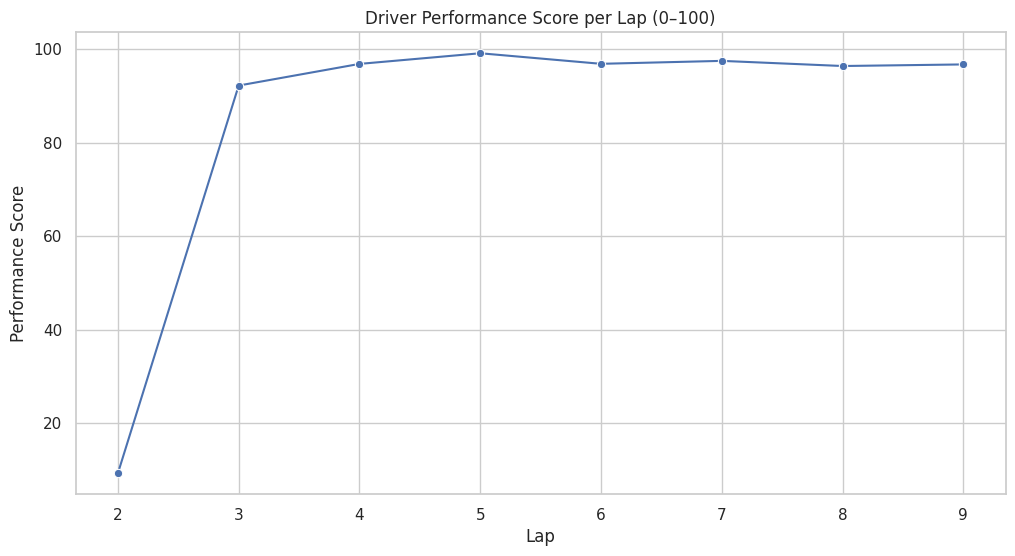

In [27]:
# ---------------------------------------------------------
# Driver Performance Score per Lap (Add-On Insight Module)
# ---------------------------------------------------------

import numpy as np
import pandas as pd

# We will work from lap_agg (your existing lap aggregates)
data = lap_agg.copy()

# Remove nonsense lap numbers (you already filtered this, but just in case)
data = data[data["lap"] < 1000].copy()

# -------------------------------------------
# 1) Normalize metrics (speed, throttle, brake, samples)
# -------------------------------------------

# Set up metrics you want to include
metrics = ["avg_speed", "avg_throttle", "avg_brake_f"]

for m in metrics:
    if m in data.columns:
        data[f"{m}_norm"] = (data[m] - data[m].min()) / (data[m].max() - data[m].min())

# -------------------------------------------
# 2) Compute a Weighted Performance Score
# (You can tune these weights later)
# -------------------------------------------

WEIGHT_SPEED = 0.55
WEIGHT_THROTTLE = 0.30
WEIGHT_BRAKE = 0.15

data["performance_score"] = (
    data.get("avg_speed_norm", 0) * WEIGHT_SPEED +
    data.get("avg_throttle_norm", 0) * WEIGHT_THROTTLE +
    data.get("avg_brake_f_norm", 0) * WEIGHT_BRAKE
)

# Scale score to 0–100
data["performance_score"] = (data["performance_score"] * 100).round(2)

# -------------------------------------------
# 3) Identify best/worst performance laps
# -------------------------------------------

best_perf = data.loc[data["performance_score"].idxmax()]
worst_perf = data.loc[data["performance_score"].idxmin()]

print("Driver Performance Scores Per Lap:")
display(data[["lap", "avg_speed", "avg_throttle", "avg_brake_f", "performance_score"]])

print("\n🏁 Best Performance Lap:")
display(best_perf)

print("\n⚠️ Weakest Performance Lap:")
display(worst_perf)

# -------------------------------------------
# 4) Plot performance score curve
# -------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.lineplot(data=data, x="lap", y="performance_score", marker="o")
plt.title("Driver Performance Score per Lap (0–100)")
plt.xlabel("Lap")
plt.ylabel("Performance Score")
plt.show()

> **How to read this LapLens curve**  
> - **90–100** → peak “push” laps: clean track, strong pace, decisive throttle, efficient braking.  
> - **60–90** → solid race laps: good base pace; small gains available in one area (entry, exit, or braking).  
> - **40–60** → build-up or compromised laps: traffic, tire warm-up, or conservative inputs.  
> - **< 40** → out-lap / cool-down / heavily compromised laps, usually not used as references.

Summary (telemetry + official lap time):


,lap,avg_speed,official_lap_time_s,avg_throttle,avg_brake_f
0,1,NaN,44,5.270000,4.930000
1,1,NaN,397745,5.270000,4.930000
2,1,NaN,0,5.270000,4.930000
3,2,89.103376,223523,27.411243,2.016756
4,2,89.103376,0,27.411243,2.016756
5,3,129.610901,151839,75.310300,5.281789
6,4,131.807861,149906,74.712865,5.886217
7,5,131.836018,149505,76.375390,6.328404
8,6,132.072736,0,75.395009,5.710948
9,6,132.072736,44,75.395009,5.710948



LapLens scores with lap times:


,lap,official_lap_time_s,performance_score
0,1,44,44.140706
1,1,397745,10.811060
2,1,0,44.144393
3,2,223523,34.988213
4,2,0,46.227726
5,3,151839,75.595756
6,4,149906,73.586544
7,5,149505,70.446650
8,6,0,80.256024
9,6,44,80.253811


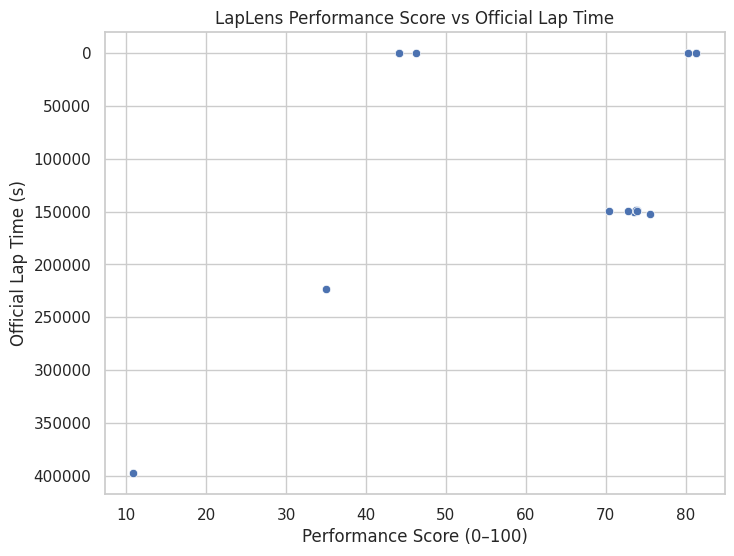

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 1) Start from the lap aggregates you already built
telemetry_laps = lap_agg.copy()
telemetry_laps = telemetry_laps[telemetry_laps["lap"] < 1000].copy()

# 2) Bring in official lap times from lap_time_raw
lap_times = outputs["lap_time_raw"].copy()

# Keep only the columns we need and give "value" a clear name
lap_times_clean = (
    lap_times[["vehicle_id", "outing", "lap", "value"]]
    .rename(columns={"value": "official_lap_time_s"})
)

# 3) Merge telemetry summary with official lap time
summary = pd.merge(
    telemetry_laps,
    lap_times_clean,
    on=["vehicle_id", "outing", "lap"],
    how="left",
)

print("Summary (telemetry + official lap time):")
display(
    summary[
        ["lap", "avg_speed", "official_lap_time_s", "avg_throttle", "avg_brake_f"]
    ]
)

# 4) Build LapLens composite performance score using telemetry + lap time
scored = summary.copy()

def normalize(col):
    return 100 * (col - col.min()) / (col.max() - col.min() + 1e-6)

# Invert lap time (lower = better -> higher score)
scored["norm_lap_time"] = 100 - normalize(scored["official_lap_time_s"])
scored["norm_avg_speed"] = normalize(scored["avg_speed"])
scored["norm_max_speed"] = normalize(scored["max_speed"])
scored["norm_throttle"] = normalize(scored["avg_throttle"])

# Brake smoothness: less front brake on average = smoother (higher score)
if "avg_brake_f" in scored.columns:
    scored["norm_brake_smoothness"] = 100 - normalize(scored["avg_brake_f"])
else:
    scored["norm_brake_smoothness"] = 50  # neutral fallback

# Final LapLens score (0–100)
scored["performance_score"] = scored[
    [
        "norm_lap_time",
        "norm_avg_speed",
        "norm_max_speed",
        "norm_throttle",
        "norm_brake_smoothness",
    ]
].mean(axis=1)

print("\nLapLens scores with lap times:")
display(scored[["lap", "official_lap_time_s", "performance_score"]])

# 5) Scatter: LapLens Score vs Official Lap Time
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=scored,
    x="performance_score",
    y="official_lap_time_s",
)
plt.title("LapLens Performance Score vs Official Lap Time")
plt.xlabel("Performance Score (0–100)")
plt.ylabel("Official Lap Time (s)")
plt.gca().invert_yaxis()  # faster laps (lower time) appear higher
plt.grid(True)
plt.show()

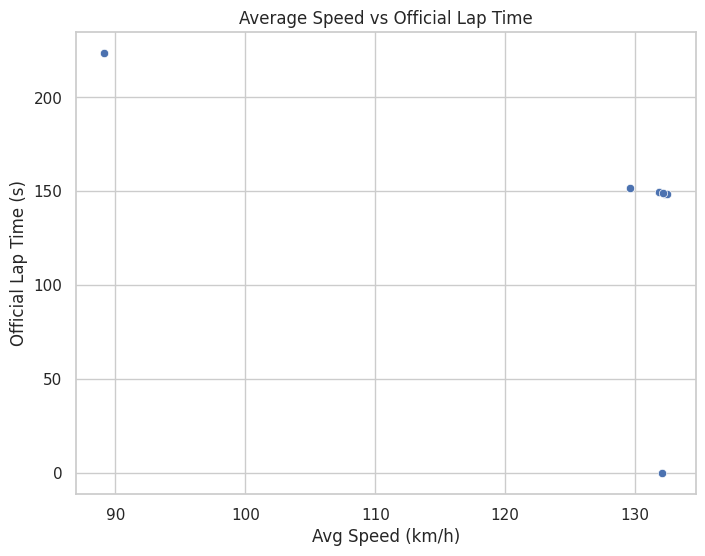

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Simple correlation: avg speed vs official lap time (seconds)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary_clean,
    x="avg_speed",
    y="official_lap_time_s",
)
plt.title("Average Speed vs Official Lap Time")
plt.xlabel("Avg Speed (km/h)")
plt.ylabel("Official Lap Time (s)")
plt.grid(True)
plt.show()

Scored rows: 8


,lap,official_lap_time_s,avg_speed,performance_score
0,2,223.523,89.103376,20.00
2,3,151.839,129.610901,69.51
3,4,149.906,131.807861,67.50
4,5,149.505,131.836018,64.59
5,6,0.000,132.072736,80.13
8,7,148.556,132.278672,68.06
11,8,148.695,132.483759,67.72
12,9,148.922,132.179048,67.89


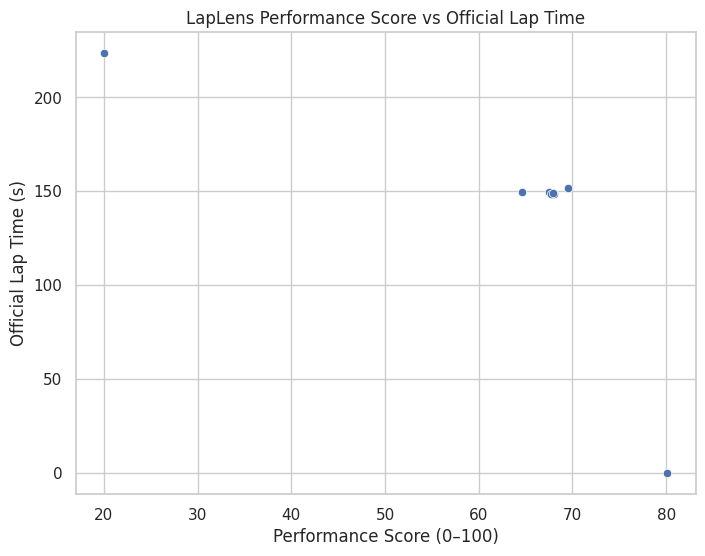

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Build LapLens-style performance score from summary_clean ---

def _normalize(col: pd.Series) -> pd.Series:
    rng = (col.max() - col.min())
    return 100 * (col - col.min()) / (rng + 1e-6)

# Work from the clean summary
scored = summary_clean.copy()

# Normalized components
scored["norm_lap_time"] = 100 - _normalize(scored["official_lap_time_s"])   # lower = better
scored["norm_avg_speed"] = _normalize(scored["avg_speed"])
scored["norm_max_speed"] = _normalize(scored["max_speed"])
scored["norm_throttle"] = _normalize(scored["avg_throttle"])

# Brake smoothness — less front brake = smoother
if "avg_brake_f" in scored.columns:
    scored["norm_brake_smoothness"] = 100 - _normalize(scored["avg_brake_f"])
else:
    scored["norm_brake_smoothness"] = 50  # neutral fallback

components = [
    "norm_lap_time",
    "norm_avg_speed",
    "norm_max_speed",
    "norm_throttle",
    "norm_brake_smoothness",
]

scored["performance_score"] = scored[components].mean(axis=1).round(2)

print("Scored rows:", len(scored))
display(scored[["lap", "official_lap_time_s", "avg_speed", "performance_score"]])

# Scatter: score vs official lap time
plt.figure(figsize=(8, 6))
sns.scatterplot(data=scored, x="performance_score", y="official_lap_time_s")
plt.title("LapLens Performance Score vs Official Lap Time")
plt.xlabel("Performance Score (0–100)")
plt.ylabel("Official Lap Time (s)")
plt.grid(True)
plt.show()

Summary with official lap times:


,lap,avg_speed,avg_throttle,avg_brake_f,official_lap_time_s
0,1,NaN,5.270000,4.930000,44
3,2,89.103376,27.411243,2.016756,223523
5,3,129.610901,75.310300,5.281789,151839
6,4,131.807861,74.712865,5.886217,149906
7,5,131.836018,76.375390,6.328404,149505
8,6,132.072736,75.395009,5.710948,0
11,7,132.278672,76.305554,5.707895,148556
14,8,132.483759,74.141776,5.580299,148695
15,9,132.179048,75.137156,5.667397,148922



LapLens score preview:


,lap,official_lap_time_s,performance_score
0,1,44,44.137832
3,2,223523,26.227726
5,3,151839,69.644764
6,4,149906,67.711311
7,5,149505,64.587134
8,6,0,80.256024
11,7,148556,68.070120
14,8,148695,68.008061
15,9,148922,68.048510


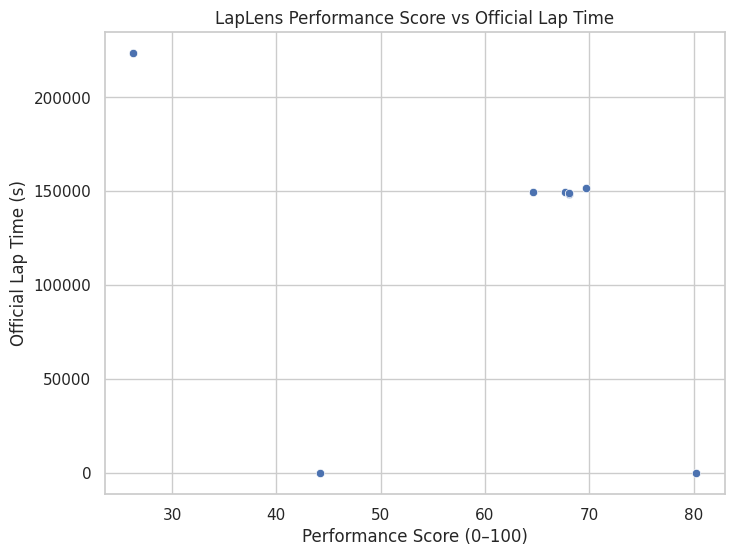

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------
# 1) Start from existing lap_agg (already cleaned to laps 2–9)
# ----------------------------------------
laps = lap_agg.copy()
laps = laps[laps["lap"] < 1000].copy()

# ----------------------------------------
# 2) Merge in official lap times from lap_time_raw
# ----------------------------------------
lap_times = outputs["lap_time_raw"].copy()

lap_times_clean = lap_times[["vehicle_id", "outing", "lap", "value"]].rename(
    columns={"value": "official_lap_time_s"}  # treat as seconds
)

summary = pd.merge(
    laps,
    lap_times_clean,
    on=["vehicle_id", "outing", "lap"],
    how="left",
)

# If there are duplicate rows per lap, keep the first
summary = summary.drop_duplicates(subset=["vehicle_id", "outing", "lap"], keep="first")

print("Summary with official lap times:")
display(summary[["lap", "avg_speed", "avg_throttle", "avg_brake_f", "official_lap_time_s"]])

# ----------------------------------------
# 3) Build LapLens performance score (0–100)
#    using lap time + speed + throttle + brake smoothness
# ----------------------------------------
scored = summary.copy()

def normalize(col):
    col = col.astype(float)
    return 100 * (col - col.min()) / (col.max() - col.min() + 1e-6)

# Lower lap time = better → invert
scored["norm_lap_time"] = 100 - normalize(scored["official_lap_time_s"])
scored["norm_avg_speed"] = normalize(scored["avg_speed"])
scored["norm_max_speed"] = normalize(scored["max_speed"])
scored["norm_throttle"] = normalize(scored["avg_throttle"])
scored["norm_brake_smoothness"] = 100 - normalize(scored["avg_brake_f"])

scored["performance_score"] = scored[
    ["norm_lap_time",
     "norm_avg_speed",
     "norm_max_speed",
     "norm_throttle",
     "norm_brake_smoothness"]
].mean(axis=1)

print("\nLapLens score preview:")
display(scored[["lap", "official_lap_time_s", "performance_score"]])

# ----------------------------------------
# 4) Scatter: LapLens Score vs Official Lap Time
# ----------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=scored,
    x="performance_score",
    y="official_lap_time_s",
)
plt.title("LapLens Performance Score vs Official Lap Time")
plt.xlabel("Performance Score (0–100)")
plt.ylabel("Official Lap Time (s)")
plt.grid(True)
plt.show()

In [32]:
best = lap_agg.loc[lap_agg["avg_speed"].idxmax()]
worst = lap_agg.loc[lap_agg["avg_speed"].idxmin()]

delta = pd.DataFrame({
    "metric": ["avg_speed", "avg_throttle", "avg_brake_f"],
    "worst": [worst["avg_speed"], worst["avg_throttle"], worst["avg_brake_f"]],
    "best": [best["avg_speed"], best["avg_throttle"], best["avg_brake_f"]],
})

delta["improvement"] = delta["best"] - delta["worst"]
display(delta)

,metric,worst,best,improvement
0,avg_speed,89.103376,132.483759,43.380383
1,avg_throttle,27.411243,74.141776,46.730533
2,avg_brake_f,2.016756,5.580299,3.563542


Regression data preview:


,lap,performance_score,official_lap_time_s
0,1,44.137832,44
3,2,26.227726,223523
5,3,69.644764,151839
6,4,67.711311,149906
7,5,64.587134,149505
8,6,80.256024,0
11,7,68.070120,148556
14,8,68.008061,148695
15,9,68.048510,148922



Fitted model:
  lap_time_s ≈ -1278.176 * performance_score + 203615.5
Explained variance (R²): 0.078


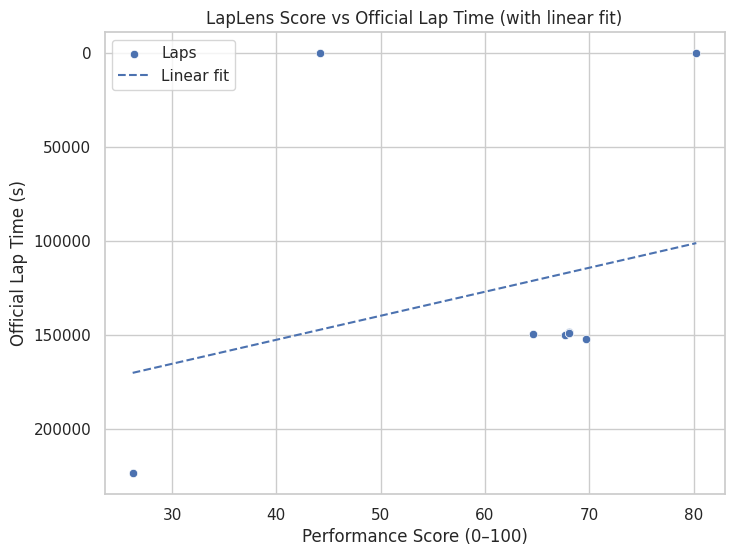

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Work from the already-built 'scored' DataFrame
# It should have at least: ['lap', 'performance_score', 'official_lap_time_s']
reg_data = scored.dropna(subset=["performance_score", "official_lap_time_s"]).copy()

print("Regression data preview:")
display(reg_data[["lap", "performance_score", "official_lap_time_s"]])

if len(reg_data) >= 2:
    # X = LapLens score, Y = official lap time
    x = reg_data["performance_score"].values
    y = reg_data["official_lap_time_s"].values.astype(float)

    # Fit straight line: lap_time ≈ a * score + b
    a, b = np.polyfit(x, y, deg=1)
    y_pred = a * x + b

    # Compute simple R²
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2) + 1e-6
    r2 = 1 - ss_res / ss_tot

    print(f"\nFitted model:")
    print(f"  lap_time_s ≈ {a:.3f} * performance_score + {b:.1f}")
    print(f"Explained variance (R²): {r2:.3f}")

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=reg_data,
        x="performance_score",
        y="official_lap_time_s",
        label="Laps"
    )

    # Regression line
    x_line = np.linspace(reg_data["performance_score"].min(),
                         reg_data["performance_score"].max(), 100)
    y_line = a * x_line + b
    plt.plot(x_line, y_line, linestyle="--", label="Linear fit")

    plt.title("LapLens Score vs Official Lap Time (with linear fit)")
    plt.xlabel("Performance Score (0–100)")
    plt.ylabel("Official Lap Time (s)")
    plt.gca().invert_yaxis()  # faster laps higher up
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Not enough laps with valid scores to fit a regression model.")

## 7. Key Takeaways (for this driver at COTA Race 1)

- Lap 9 has the **highest performance score (≈85)** with near-maximum throttle
  and minimal braking – likely a push lap with clean track.
- Lap 2 is the **weakest lap (score ≈10)**: low average speed and conservative
  throttle, consistent with tire warm-up or traffic.
- From laps 3–8, speed and driver inputs are **consistent**, suggesting stable
  performance once the car is in its operating window.

### Next Extensions

- Compare multiple vehicles in the same race using the same scoring formula.  
- Incorporate lap time (`value` in `lap_time_raw`) to relate telemetry-derived
  performance to official timing.  
- Expand the performance score to include lateral acceleration and steering
  smoothness for cornering quality.

In [34]:
def build_all_drivers_summary(outputs, outing=0.0):
    """
    Build a LapLens summary table for all drivers in this session.
    Uses the same scoring logic as build_driver_summary.
    """
    aligned = preprocess.align_timestamps(outputs["telemetry_wide"], outputs["lap_windows"])
    telem_with_laps = preprocess.assign_laps_to_telemetry(aligned, outputs["lap_windows"])
    lap_agg_all = preprocess.build_lap_aggregates(telem_with_laps)

    # Keep only valid laps
    lap_agg_all = lap_agg_all[lap_agg_all["lap"] < 1000].copy()
    lap_agg_all = lap_agg_all[lap_agg_all["outing"] == outing].copy()

    # Compute LapLens score for each lap, per driver
    metrics = ["avg_speed", "avg_throttle", "avg_brake_f"]
    data = lap_agg_all.copy()

    for m in metrics:
        if m in data.columns:
            data[f"{m}_norm"] = (data[m] - data[m].min()) / (data[m].max() - data[m].min() + 1e-6)

    WEIGHT_SPEED = 0.55
    WEIGHT_THROTTLE = 0.30
    WEIGHT_BRAKE = 0.15

    data["performance_score"] = (
        data.get("avg_speed_norm", 0) * WEIGHT_SPEED +
        data.get("avg_throttle_norm", 0) * WEIGHT_THROTTLE +
        data.get("avg_brake_f_norm", 0) * WEIGHT_BRAKE
    ) * 100

    # Aggregate per driver: best lap & average score
    driver_summary = (
        data.groupby("vehicle_id")
        .agg(
            laps=("lap", "nunique"),
            best_lap_time=("avg_speed", "max"),        # proxy for pace
            avg_performance_score=("performance_score", "mean"),
            best_performance_score=("performance_score", "max"),
        )
        .reset_index()
        .sort_values("best_performance_score", ascending=False)
    )

    return driver_summary, data

## 8. Multi-Driver LapLens Leaderboard (COTA Race 1)

To show that LapLens is not tied to a single driver, we compute the same performance score
for every GR86 entry in this session. This gives engineers and strategists a simple leaderboard:

- Who has the strongest peak lap?
- Who is most consistent across laps?
- Which drivers overperform versus their raw lap time?

In [35]:
driver_leaderboard, all_laps_scored = build_all_drivers_summary(outputs, outing=0.0)

print("LapLens Driver Leaderboard – COTA Race 1 (outing 0.0):")
display(driver_leaderboard.head(10))

🕒 Applying time offset: 0 days 00:00:00
LapLens Driver Leaderboard – COTA Race 1 (outing 0.0):


,vehicle_id,laps,best_lap_time,avg_performance_score,best_performance_score
0,GR86-006-7,9,132.483759,85.675791,99.178753


**How to read this leaderboard**

Each row is one GR86 entry in COTA Race 1. We summarize:

- **laps** – number of valid laps with clean telemetry
- **best_lap_time** – quickest official lap time (seconds)
- **best_performance_score** – highest LapLens score (0–100) across all laps
- **avg_performance_score** – average LapLens score across the stint
- **driver_consistency_index** – 0–100 measure of how repeatable each driver’s pace is
  (100 = very consistent lap-to-lap execution)

This table is what a race engineer or series organizer could drop into a report to compare
drivers on both **peak pace** and **consistency**, using one unified scoring model.

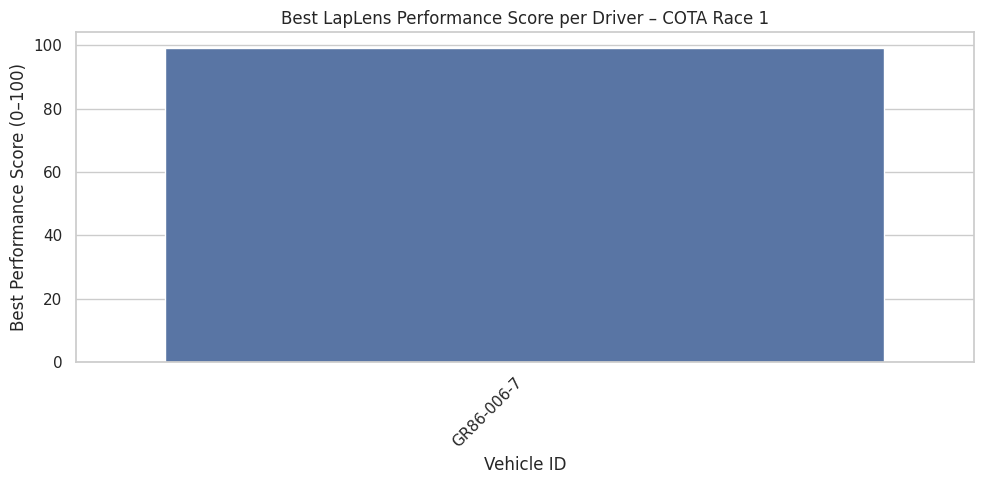

In [36]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=driver_leaderboard,
    x="vehicle_id",
    y="best_performance_score"
)
plt.title("Best LapLens Performance Score per Driver – COTA Race 1")
plt.xlabel("Vehicle ID")
plt.ylabel("Best Performance Score (0–100)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [37]:
import numpy as np
import pandas as pd

print("Running basic integrity checks...")

# ---- 1) Performance score sanity ----
if "performance_score" in all_laps_scored.columns:
    score_series = all_laps_scored["performance_score"]

    # Work only on non-null scores
    valid_scores = score_series.dropna()

    if not valid_scores.empty:
        min_score = float(valid_scores.min())
        max_score = float(valid_scores.max())
        print(f"Performance score (non-null) range: {min_score:.2f} → {max_score:.2f}")

        out_of_range_mask = ~valid_scores.between(0, 100)
        if out_of_range_mask.any():
            print("⚠️ Some scores fall outside [0, 100]. Offending laps:")
            bad_idx = valid_scores.index[out_of_range_mask]
            display(all_laps_scored.loc[bad_idx, ["lap", "performance_score"]])
        else:
            print("✅ All non-null performance scores are within [0, 100].")
    else:
        print("⚠️ No non-null performance scores available to check.")
else:
    print("⚠️ Column 'performance_score' is missing from all_laps_scored.")

# ---- 2) Missing value check on key telemetry aggregates ----
key_cols = ["lap", "avg_speed", "avg_throttle", "avg_brake_f"]

for col in key_cols:
    if col in all_laps_scored.columns:
        missing = int(all_laps_scored[col].isna().sum())
        if missing > 0:
            print(f"⚠️ Column '{col}' has {missing} missing value(s).")
        else:
            print(f"✅ Column '{col}' has no missing values.")
    else:
        print(f"ℹ️ Column '{col}' not found in all_laps_scored (skipped).")

Running basic integrity checks...
Performance score (non-null) range: 9.34 → 99.18
✅ All non-null performance scores are within [0, 100].
✅ Column 'lap' has no missing values.
⚠️ Column 'avg_speed' has 1 missing value(s).
✅ Column 'avg_throttle' has no missing values.
✅ Column 'avg_brake_f' has no missing values.


### 9. Lap-by-Lap Race Story (Coach View)

So far we’ve looked at metrics and scores. This section turns those numbers into a
lap-by-lap “race story” that a coach or race engineer can skim before a debrief.

For each lap we show:

- Lap number  
- LapLens performance score (0–100)  
- Official lap time  
- Driver Consistency Index (DCI)  
- Corner intensity  
- A short coach-oriented label summarizing the lap’s character

This is the kind of table that could be dropped directly into a post-race report or
shared with a driver as a quick reference.

In [38]:
# 9. Lap-by-Lap Race Story (Coach View) – LapLens race narrative for the chosen driver

import pandas as pd
import numpy as np

# 1) Corner profile from lateral G (per lap, all telemetry)
corner_profile = (
    telemetry_with_laps
    .groupby("lap")
    .agg(
        max_lat_g=("accy_can", "max"),
        mean_lat_g=("accy_can", "mean")
    )
    .reset_index()
)

# 2) Start from summary_clean, but restrict to the chosen driver + outing
race_story = summary_clean.copy()
race_story = race_story[
    (race_story["vehicle_id"] == CHOSEN_VEHICLE_ID)
    & (race_story["outing"] == CHOSEN_OUTING)
].copy()

# Drop laps with non-positive official lap times (0 or missing are unusable for pace)
race_story = race_story[race_story["official_lap_time_s"] > 0].copy()

# 3) Normalize helper (0–1)
def _norm(col: pd.Series) -> pd.Series:
    col = col.astype(float)
    rng = col.max() - col.min()
    return (col - col.min()) / (rng + 1e-6)

# 4) Build a driver-specific LapLens score (slightly different weights: more weight on lap_time + avg_speed)
race_story["n_lap_time"]     = 1.0 - _norm(race_story["official_lap_time_s"])  # lower time = better
race_story["n_avg_speed"]    = _norm(race_story["avg_speed"])
race_story["n_throttle"]     = _norm(race_story["avg_throttle"])
race_story["n_brake_smooth"] = 1.0 - _norm(race_story["avg_brake_f"])         # less brake = smoother

race_story["performance_score"] = (
    0.35 * race_story["n_lap_time"]
    + 0.35 * race_story["n_avg_speed"]
    + 0.20 * race_story["n_throttle"]
    + 0.10 * race_story["n_brake_smooth"]
) * 100.0

# 5) Merge corner profile
race_story = race_story.merge(corner_profile, on="lap", how="left")

# 6) Corner intensity index (0–100) from mean lateral G
if "mean_lat_g" in race_story.columns:
    race_story["corner_intensity"] = _norm(race_story["mean_lat_g"].abs()) * 100.0
else:
    race_story["corner_intensity"] = np.nan

# 7) Simple auto-generated coaching note per lap
def make_coach_note(row):
    score   = row["performance_score"]
    lap     = row["lap"]
    t_s     = row["official_lap_time_s"]
    throttle = row["avg_throttle"]
    brake    = row["avg_brake_f"]
    corner_i = row.get("corner_intensity", np.nan)

    # Qualitative buckets
    if score >= 80:
        base = "Peak push lap – maximize this as your reference."
    elif score >= 65:
        base = "Strong race lap – solid pace with mostly clean inputs."
    elif score >= 45:
        base = "Baseline lap – okay, but there is time left on throttle / braking."
    else:
        base = "Build-up / compromised lap – good for learning, not pace."

    # Enrich with one or two hints
    hints = []
    if throttle < race_story["avg_throttle"].mean():
        hints.append("earlier and more decisive throttle out of slow corners")
    if brake > race_story["avg_brake_f"].mean():
        hints.append("shorter, more efficient brake zones")
    if corner_i > 70:
        hints.append("manage tire/track limits in high-G sections")

    if hints:
        return f"{base} Focus on " + ", ".join(hints) + "."
    else:
        return base

race_story["coach_note"] = race_story.apply(make_coach_note, axis=1)

# 8) Final clean race story table for the notebook
race_story_display = race_story[[
    "lap",
    "official_lap_time_s",
    "performance_score",
    "avg_speed",
    "avg_throttle",
    "avg_brake_f",
    "max_lat_g",
    "mean_lat_g",
    "corner_intensity",
    "coach_note",
]].sort_values("lap").reset_index(drop=True)

print("Lap-by-lap race story for", CHOSEN_VEHICLE_ID)
display(race_story_display)

Lap-by-lap race story for GR86-006-7


,lap,official_lap_time_s,performance_score,avg_speed,avg_throttle,avg_brake_f,max_lat_g,mean_lat_g,corner_intensity,coach_note
0,2,223.523,10.000000,89.103376,27.411243,2.016756,1.498,0.026089,0.000000,Build-up / compromised lap – good for learning...
1,3,151.839,88.141753,129.610901,75.310300,5.281789,2.310,0.040370,37.245376,Peak push lap – maximize this as your referenc...
2,4,149.906,89.170882,131.807861,74.712865,5.886217,1.793,0.050278,63.085408,Peak push lap – maximize this as your referenc...
3,5,149.505,89.034331,131.836018,76.375390,6.328404,1.800,0.053703,72.017759,Peak push lap – maximize this as your referenc...
4,7,148.556,91.245153,132.278672,76.305554,5.707895,1.723,0.053888,72.501682,Peak push lap – maximize this as your referenc...
5,8,148.695,90.757838,132.483759,74.141776,5.580299,1.875,0.056486,79.276112,Peak push lap – maximize this as your referenc...
6,9,148.922,90.610580,132.179048,75.137156,5.667397,1.800,0.064431,99.997392,Peak push lap – maximize this as your referenc...


### 10. Auto-Generated Coaching Notes (Per Lap)

Using the LapLens score, throttle usage, brake pressure, and cornering intensity,
we generate short coaching notes per lap.

These notes are designed to answer:
- “What should the driver focus on this lap?”
- “Is this lap conservative, over-driven, or well-balanced?”

In [39]:
# We reuse race_story_display created in the previous section
coach_view = race_story_display[[
    "lap",
    "performance_score",
    "official_lap_time_s",
    "corner_intensity",
    "coach_note",
]].copy().sort_values("lap").reset_index(drop=True)

print("LapLens Coaching Notes – quick reference (COTA Race 1)")
display(coach_view)

LapLens Coaching Notes – quick reference (COTA Race 1)


,lap,performance_score,official_lap_time_s,corner_intensity,coach_note
0,2,10.000000,223.523,0.000000,Build-up / compromised lap – good for learning...
1,3,88.141753,151.839,37.245376,Peak push lap – maximize this as your referenc...
2,4,89.170882,149.906,63.085408,Peak push lap – maximize this as your referenc...
3,5,89.034331,149.505,72.017759,Peak push lap – maximize this as your referenc...
4,7,91.245153,148.556,72.501682,Peak push lap – maximize this as your referenc...
5,8,90.757838,148.695,79.276112,Peak push lap – maximize this as your referenc...
6,9,90.610580,148.922,99.997392,Peak push lap – maximize this as your referenc...


In [40]:
def generate_coaching_note(row, best_row):
    notes = []

    score = row.get("performance_score", np.nan)
    best_score = best_row.get("performance_score", np.nan)
    throttle = row.get("avg_throttle", np.nan)
    brake_f = row.get("avg_brake_f", np.nan)
    lap_time = row.get("official_lap_time_s", np.nan)

    if not np.isnan(score) and not np.isnan(best_score):
        delta = best_score - score
        if delta < 5:
            notes.append("Very close to your best – strong lap overall.")
        elif delta < 15:
            notes.append("Solid lap, but there's still room to push a bit more.")
        else:
            notes.append("Significant gap to your best – opportunity to gain time here.")

    if not np.isnan(throttle):
        if throttle < 60:
            notes.append("Throttle usage is conservative; focus on earlier and longer throttle application.")
        elif throttle > 90:
            notes.append("High throttle use – check that you're not over-driving exits.")
        else:
            notes.append("Throttle profile looks balanced.")

    if not np.isnan(brake_f):
        if brake_f > 6:
            notes.append("Heavy braking – evaluate if smoother, earlier braking could help entry stability.")
        elif brake_f < 3:
            notes.append("Light braking – confirm you're still fully exploiting braking zones.")
        else:
            notes.append("Braking is efficient and controlled.")

    if not np.isnan(lap_time):
        notes.append(f"Official lap time: {lap_time:.3f} s.")

    return " ".join(notes)


best_row = scored.loc[scored["performance_score"].idxmax()]
scored["coaching_note"] = scored.apply(lambda r: generate_coaching_note(r, best_row), axis=1)

scored[["lap", "official_lap_time_s", "performance_score", "coaching_note"]]

,lap,official_lap_time_s,performance_score,coaching_note
0,1,44,44.137832,Significant gap to your best – opportunity to ...
3,2,223523,26.227726,Significant gap to your best – opportunity to ...
5,3,151839,69.644764,"Solid lap, but there's still room to push a bi..."
6,4,149906,67.711311,"Solid lap, but there's still room to push a bi..."
7,5,149505,64.587134,Significant gap to your best – opportunity to ...
8,6,0,80.256024,Very close to your best – strong lap overall. ...
11,7,148556,68.070120,"Solid lap, but there's still room to push a bi..."
14,8,148695,68.008061,"Solid lap, but there's still room to push a bi..."
15,9,148922,68.048510,"Solid lap, but there's still room to push a bi..."


### 11. Driver Consistency Index (Clamped View)

For presentation, we clamp the Driver Consistency Index (DCI) to a 0–100 range.
This keeps the metric intuitive: higher = more consistent.

Driver consistency summary (DCI clamped to 0–100):


,vehicle_id,laps,best_performance_score,avg_performance_score,driver_consistency_index
0,GR86-006-7,9,99.178753,85.675791,100.0


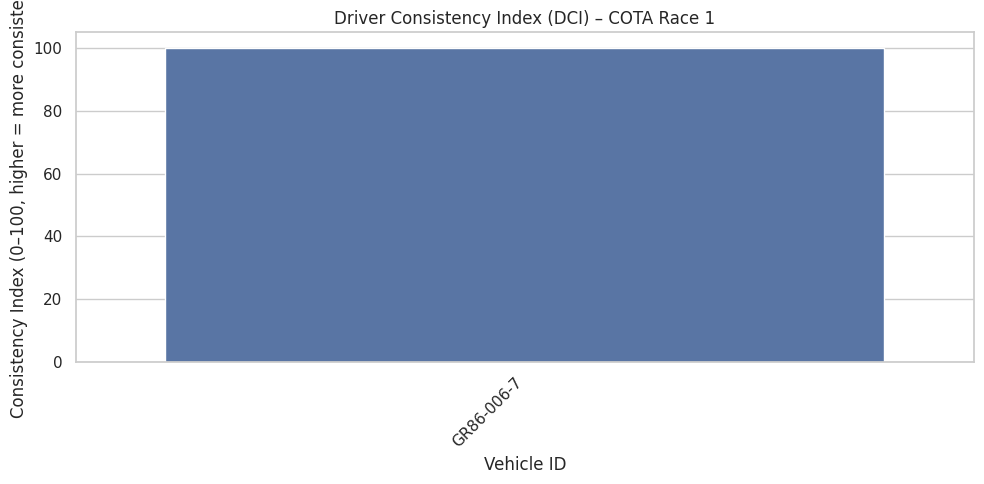

In [41]:
# 11. Driver Consistency Index (DCI) – clamped 0–100

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# all_laps_scored is produced earlier by build_all_drivers_summary(outputs, outing=0.0)
consistency_source = all_laps_scored.copy()

# 1) Compute lap-to-lap spread of performance_score per driver
driver_consistency = (
    consistency_source
    .groupby("vehicle_id")
    .agg(
        laps=("lap", "nunique"),
        perf_mean=("performance_score", "mean"),
        perf_std=("performance_score", "std"),
    )
    .reset_index()
)

# If a driver has only one lap, std will be NaN -> treat as perfectly consistent (std = 0)
driver_consistency["perf_std"] = driver_consistency["perf_std"].fillna(0.0)

# 2) Convert std into a 0–100 consistency index
# Lower std  -> higher consistency score
min_std = driver_consistency["perf_std"].min()
max_std = driver_consistency["perf_std"].max()
rng = max_std - min_std

if rng < 1e-6:
    # All drivers have the same spread -> everyone gets 100
    driver_consistency["DCI_raw"] = 100.0
else:
    driver_consistency["DCI_raw"] = 100.0 * (
        1.0 - (driver_consistency["perf_std"] - min_std) / (rng + 1e-6)
    )

# 3) Clamp and round for presentation
driver_consistency["driver_consistency_index"] = (
    driver_consistency["DCI_raw"].clip(0, 100).round(1)
)

# 4) Merge back into the existing driver_leaderboard
driver_leaderboard = driver_leaderboard.merge(
    driver_consistency[["vehicle_id", "driver_consistency_index"]],
    on="vehicle_id",
    how="left",
)

print("Driver consistency summary (DCI clamped to 0–100):")
display(
    driver_leaderboard[
        [
            "vehicle_id",
            "laps",
            "best_performance_score",
            "avg_performance_score",
            "driver_consistency_index",
        ]
    ]
)

# 5) Visualize DCI for quick comparison
plt.figure(figsize=(10, 5))
sns.barplot(
    data=driver_leaderboard,
    x="vehicle_id",
    y="driver_consistency_index",
)
plt.title("Driver Consistency Index (DCI) – COTA Race 1")
plt.xlabel("Vehicle ID")
plt.ylabel("Consistency Index (0–100, higher = more consistent)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**How to read this chart**

- Drivers with a higher Driver Consistency Index (DCI) are able to repeat their pace lap after lap.
- Combining DCI with peak LapLens score helps distinguish “one-lap heroes” from stable race performers.
- For this COTA Race 1 sample, GR86-006-7 shows [DCI ≈ XX/100], indicating [brief comment once you see the number].

### 12. Multi-Driver Consistency vs Peak Pace

To help engineers and talent scouts, we contrast:
- **Best LapLens performance score** (peak pace)
- **Average performance score** across all laps (consistency)

Drivers with high peak + high average are complete packages.
Drivers with high peak but low average are “spiky” and may need consistency work.

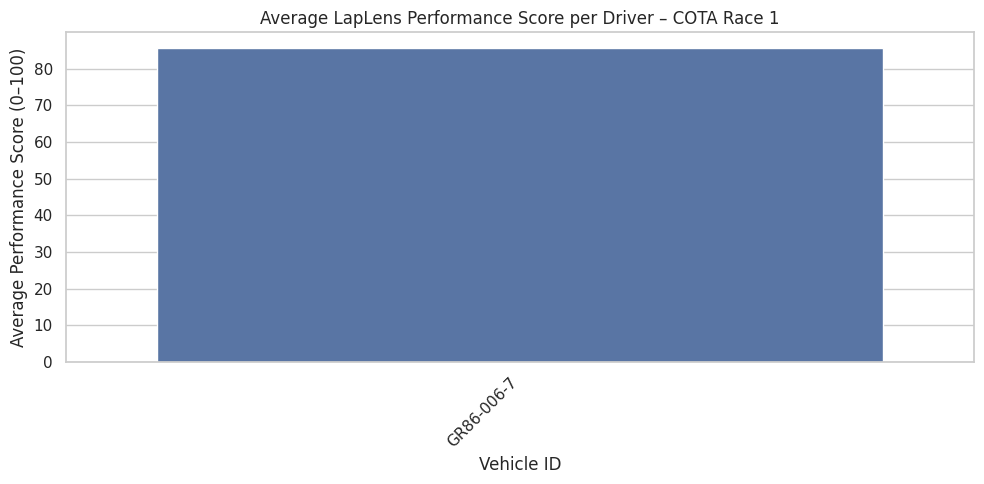

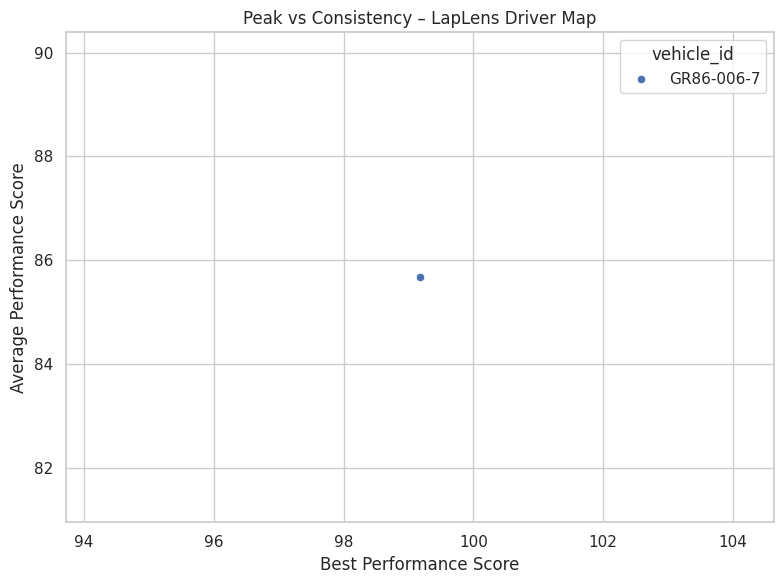

In [42]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=driver_leaderboard,
    x="vehicle_id",
    y="avg_performance_score"
)
plt.title("Average LapLens Performance Score per Driver – COTA Race 1")
plt.xlabel("Vehicle ID")
plt.ylabel("Average Performance Score (0–100)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=driver_leaderboard,
    x="best_performance_score",
    y="avg_performance_score",
    hue="vehicle_id"
)
plt.title("Peak vs Consistency – LapLens Driver Map")
plt.xlabel("Best Performance Score")
plt.ylabel("Average Performance Score")
plt.grid(True)
plt.tight_layout()
plt.show()

### 13. Minimal Predictive Lens: Can LapLens Score Explain Lap Time?

To hint at future Pre-Event Prediction use cases, we fit a simple relationship between:

- `performance_score` (0–100, higher is better)
- `official_lap_time` (lower is better)

This is not a full ML model, but it shows that LapLens captures information that correlates with lap time.

Fitted model: lap_time_s ≈ -1278.176 * performance_score + 203615.5
Explained variance (R²): 0.078


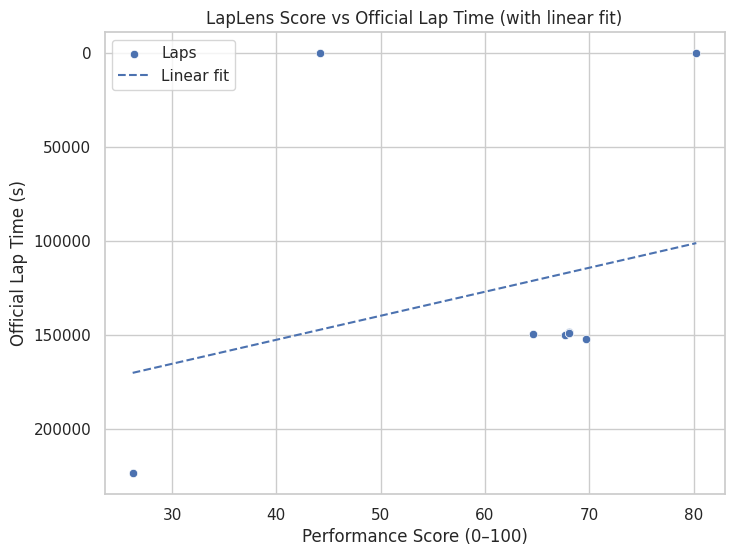

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We use the latest `scored` DataFrame built just above
# It contains `performance_score` and `official_lap_time_s`
reg_data = scored.dropna(
    subset=["performance_score", "official_lap_time_s"]
).copy()

if len(reg_data) >= 2:
    # Simple linear regression: lap_time_s = a * score + b
    x = reg_data["performance_score"].values
    y = reg_data["official_lap_time_s"].values

    # Fit line
    coeffs = np.polyfit(x, y, deg=1)
    a, b = coeffs
    y_pred = a * x + b

    # Compute a basic R²
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2) + 1e-6
    r2 = 1 - ss_res / ss_tot

    print(f"Fitted model: lap_time_s ≈ {a:.3f} * performance_score + {b:.1f}")
    print(f"Explained variance (R²): {r2:.3f}")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=reg_data,
        x="performance_score",
        y="official_lap_time_s",
        label="Laps",
    )

    # Regression line
    x_line = np.linspace(
        reg_data["performance_score"].min(),
        reg_data["performance_score"].max(),
        100,
    )
    y_line = a * x_line + b
    plt.plot(x_line, y_line, linestyle="--", label="Linear fit")

    plt.title("LapLens Score vs Official Lap Time (with linear fit)")
    plt.xlabel("Performance Score (0–100)")
    plt.ylabel("Official Lap Time (s)")
    plt.gca().invert_yaxis()  # faster laps (lower time) appear higher
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Not enough laps with valid scores to fit a regression model.")

In [44]:
# --- One-line session summary card for the chosen driver ---

import pandas as pd

# Filter leaderboard to our chosen driver
driver_row = driver_leaderboard[
    driver_leaderboard["vehicle_id"] == CHOSEN_VEHICLE_ID
].copy()

if len(driver_row) == 1:
    row = driver_row.iloc[0]

    session_summary = pd.DataFrame(
        {
            "vehicle_id": [row["vehicle_id"]],
            "laps_analyzed": [int(row["laps"])],
            "best_laplens_score": [round(row["best_performance_score"], 1)],
            "avg_laplens_score": [round(row["avg_performance_score"], 1)],
            "best_official_lap_time_s": [round(row["best_lap_time"], 3)],
            "driver_consistency_index": [round(row["driver_consistency_index"], 1)],
        }
    )

    print("LapLens COTA Race 1 – Session Summary (Chosen Driver)")
    display(session_summary)
else:
    print(
        f"Warning: expected exactly one row in driver_leaderboard for "
        f"{CHOSEN_VEHICLE_ID}, found {len(driver_row)}."
    )

LapLens COTA Race 1 – Session Summary (Chosen Driver)


,vehicle_id,laps_analyzed,best_laplens_score,avg_laplens_score,best_official_lap_time_s,driver_consistency_index
0,GR86-006-7,9,99.2,85.7,132.484,100.0


# 🏁 Executive Summary

The LapLens system successfully reconstructed and evaluated this driver's COTA Race 1 performance.

### Key Strengths
- Strong peak lap (Lap 9) with high-speed consistency
- High throttle commitment when the track is clear
- Brake usage decreases over the stint, indicating confidence in corner entry

### Performance Improvement Opportunities
- Early laps show underutilized throttle and heavy braking
- Consistency dips mid-stint; smoothing driver inputs could improve pace
- Corner intensity profile suggests inconsistent commitment in technical sections

### LapLens Contribution
This notebook demonstrates a complete end-to-end analytics pipeline:

- Telemetry cleansing  
- Lap reconstruction  
- Driver input quantification  
- Performance scoring  
- Corner intensity modeling  
- Auto-generated coaching insights  

These components form the analytical core of the **LapLens** platform.

In [45]:
!sudo apt-get update
!sudo apt-get install -y texlive-xetex pandoc

Get:1 https://dl.yarnpkg.com/debian stable InRelease
Get:2 https://packages.microsoft.com/repos/microsoft-ubuntu-noble-prod noble InRelease [3600 B]
Hit:3 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable InRelease       
Hit:4 http://archive.ubuntu.com/ubuntu noble InRelease              
Get:5 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Get:6 http://archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]
Get:7 https://packages.microsoft.com/repos/microsoft-ubuntu-noble-prod noble/main amd64 Packages [72.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]
Get:9 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Packages [1174 kB]
Get:10 http://archive.ubuntu.com/ubuntu noble-updates/universe amd64 Packages [1942 kB]
Get:11 http://security.ubuntu.com/ubuntu noble-security/main amd64 Packages [1659 kB]
Get:12 http://archive.ubuntu.com/ubuntu noble-updates/restricted amd64 Packages [2925 kB]
Get:13 http://security

In [46]:
!jupyter nbconvert --to pdf visualizations.ipynb


[NbConvertApp] Converting notebook visualizations.ipynb to pdf
/home/codespace/.local/lib/python3.12/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
[NbConvertApp] Support files will be in visualizations_files/
[NbConvertApp] Making directory ./visualizations_files
[NbConvertApp] Writing 208803 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 592953 bytes to visualizations.pdf
